## Analyze A/B Test Results

A/B testing, also known as split testing, refers to a randomized experimentation process wherein two or more versions of a variable (web page, page element, etc.) are shown to different segments of website visitors at the same time to determine which version leaves the maximum impact and drive business metrics.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

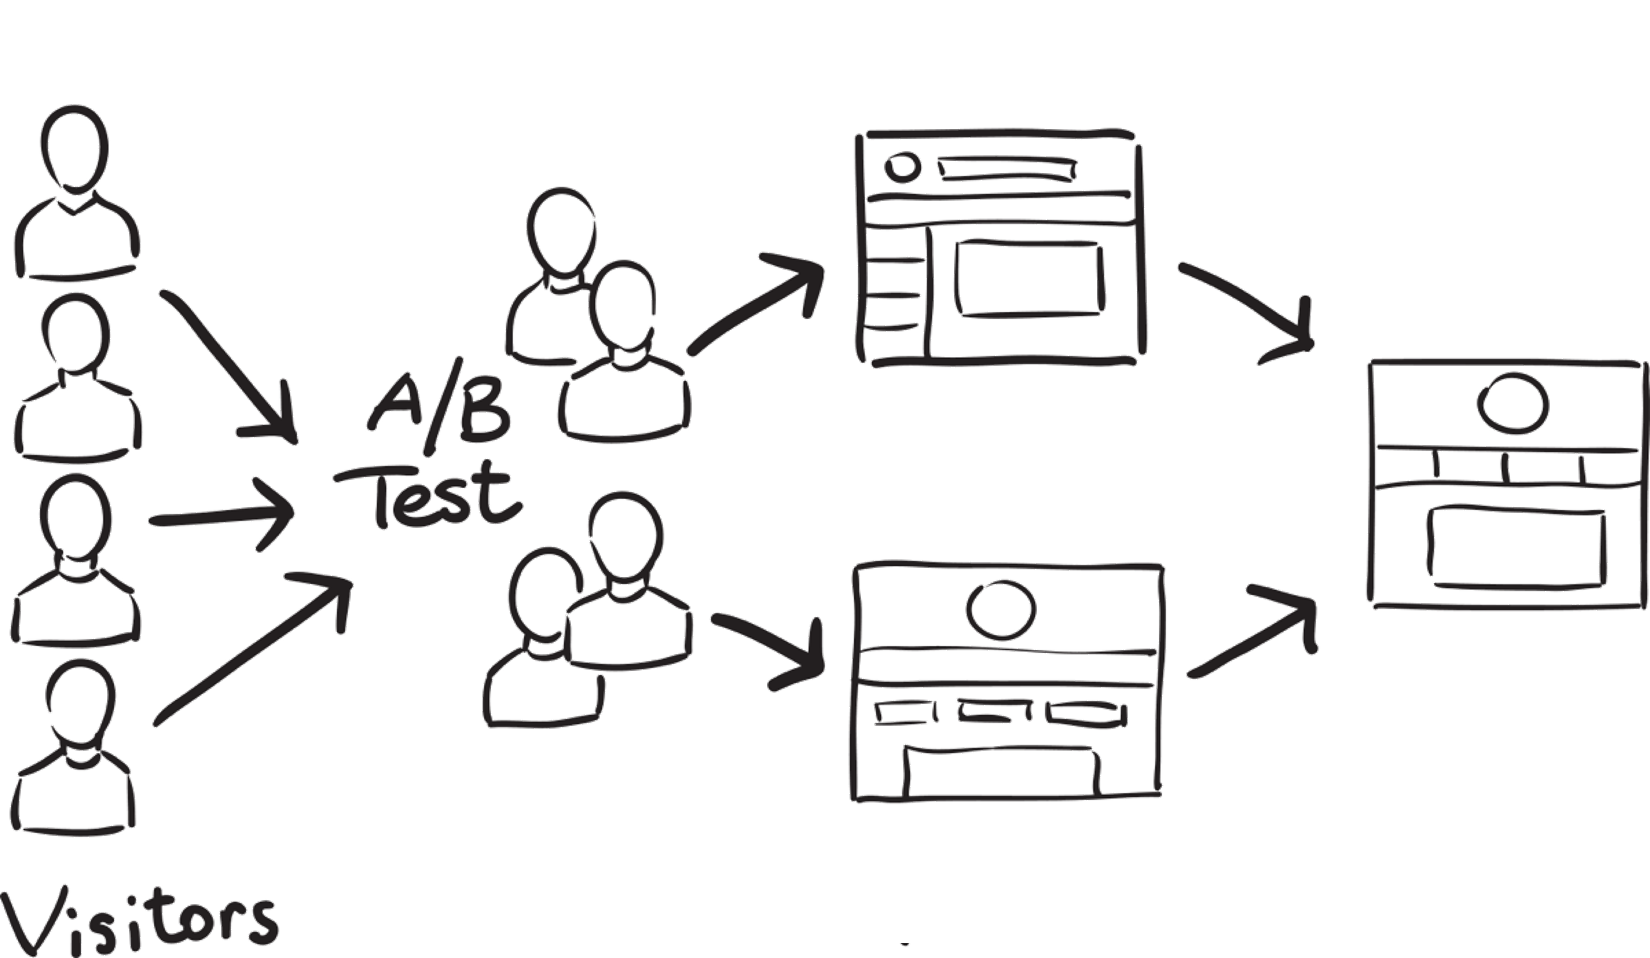

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [ ]:
# Importing the necessary modules & setting the random seed to (42):
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [ ]:
# Reading raw data:
raw_data = pd.read_csv('../input/udacity-analyze-ab-test-results/ab_data.csv', parse_dates=['timestamp'])

In [ ]:
# Exploring the first 5 rows:
raw_data.head()

b. Use the below cell to find the number of rows in the dataset.

In [ ]:
# Getting number of rows:
raw_data.shape[0]

c. The number of unique users in the dataset.

In [ ]:
# Identifying the number of unique user_id values:
raw_data['user_id'].nunique()

d. The proportion of users converted.

In [ ]:
# Conversion rate (cr) in general (before cleaning data):
p_raw_data = raw_data['converted'].mean()
p_raw_data

e. The number of times the `treatment` and `new_page` don't line up.

In [ ]:
# Setting a condition to capture all non-aligned values using bitwise exclusive or:
not_aligned = (raw_data['group'] == 'treatment') ^ (raw_data['landing_page'] == 'new_page')

In [ ]:
# The number of non-aligned values:
not_aligned.sum()

Note that the number of times the `treatment` and `new_page` don't line up is the same as the number of times the `control` and `old_page` don't line up!

f. Do any of the rows have missing values?

In [ ]:
raw_data.isna().sum()

<font color='red'>**No columns have missing values.**</font>

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [ ]:
# Filtering out non-aligned values:
df2 = raw_data.query("~ @not_aligned").copy()

In [ ]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

<font color='red'>**All done!**</font>

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [ ]:
# The same code as before:
df2['user_id'].nunique()

b. There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
# Setting a condition to capture duplicated user_id values:
duplicated_id = df2['user_id'].duplicated()

In [ ]:
df2.query("@duplicated_id")['user_id']

c. What is the row information for the repeat **user_id**? 

In [ ]:
df2.query("@duplicated_id")

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [ ]:
df2.drop_duplicates('user_id', inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [ ]:
# Defining a function to calculate CR for a given group:
def calculate_cr(df, gp=None):
    
    """
    Calculates CR for a given group.
    
    Args:
    (pandas DataFrame) The dataset.
    (str) The group name.
    
    Returns:
    (float) The conversion rate.
    """
    
    # Zooming in the required part of the data:
    if gp:
        df = df.query("group == @gp")
    
    # Calculating & returning CR:
    return df['converted'].mean()

In [ ]:
# Conversion rate in general (after cleaning data):
p_general = calculate_cr(df2)
p_general

b. Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
p_old = calculate_cr(df2, 'control')
p_old

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
p_new = calculate_cr(df2, 'treatment')
p_new

In [ ]:
# Plotting CR in different groups:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flatten()

axs[0].set_title("CR in Control Group", fontsize=20)
df2.query("group == 'control'")['converted'].value_counts().plot.bar(ax=axs[0])

axs[1].set_title("CR in Treatment Group", fontsize=20)
df2.query("group == 'treatment'")['converted'].value_counts().plot.bar(ax=axs[1])

axs[2].set_title("CR in Both Groups", fontsize=20)
df2['converted'].value_counts().plot.bar(ax=axs[2]);

<font color='red'>**They are nearly identical!**</font>

d. What is the probability that an individual received the new page?

In [ ]:
p_treatment = (df2['landing_page'] == 'new_page').mean()
p_treatment

<font color='red'>**The probability of receiving either pages is nearly the same!**</font>

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

<font color='red'>**There is no big diffference between the conversion rates for both groups. However, without using inferential statistical methods we can't tell for sure, we can't quantify our doubt!**</font>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

##### <font color='red'>**The null & alternative hypotheses are**:</font>
##### 1. Null hypothesis: p_new - p_old <= 0, as follows:
$$H_0: P_{new} - P_{old} \leq 0$$

##### 2. Alternative hypothesis: p_new - p_old > 0 (one-sided), as follows:
$$H_1: P_{new} - P_{old} > 0$$

##### <font color='red'>**I have ve represented 3 approaches**:</font>
##### 1. Using **bootstrapping**.
##### 2. Using **probability simulation** as suggested in the template.
##### 3. Using **traditional statistical methods**.

##### <font color='red'>**I have edited some cells to represent my own approach, I hope it is fine!**</font>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal.

##### **<font color='red'>My hypotheses are mentioned above.</font>**

#### <font color='red'>First</font>: **Using confidence intervals & hypothesis testing by bootstrapping.**

##### 1. Calculating the statistic of interest (the available evidence based on the data):

In [ ]:
p_old, p_new

In [ ]:
diff_in_p = p_new - p_old
diff_in_p

##### 2. Building the sampling distribution for dif_in_p using bootstrapping:

In [ ]:
# Optimizing the dataset before bootstrapping:
df_optimized = df2[['group', 'converted']].copy()
df_optimized['group'] = df_optimized['group'].astype('category')
df_optimized['converted'] = df_optimized['converted'].astype('int8')

In [ ]:
# Defining a bootstrapping function:
def btstrp_func(df, iters, func, groups, size=None):
    
    """
    Builds a sampling distribution for difference in
    means by bootstrapping.
    
    Args:
    (pandas DataFrame) The dataset.
    (int) Number of iterations.
    (function) A function to calculate the CR.
    (list) An array containing the two group labels.
    (int) The size of the sampling.
    
    Returns:
    (numpy array) The sampling distribultion for p_old.
    (numpy array) The sampling distribultion for p_new.
    (numpy array) The sampling distribultion for difference in means.
    """
    
    # Initializing 3 empty lists to keep track
    # of statistics of interest:
    stat_old_arr, stat_new_arr, diff_arr = [], [], []
    
    # Setting the size of the bootstrapped sample:
    if not size:
        size = df.shape[0]
    
    # Bootstrapping & calculating statistics of interest:
    for i in range(iters):
        btstrp_df = df.sample(n=size, replace=True)
    
        stat_old = func(btstrp_df, groups[0])
        stat_old_arr.append(stat_old)
    
        stat_new = func(btstrp_df, groups[1])
        stat_new_arr.append(stat_new)
    
        diff_arr.append(stat_new - stat_old)
    
    # Converting lists into numpy arrays:
    stat_old_arr = np.array(stat_old_arr)
    stat_new_arr = np.array(stat_new_arr)
    diff_arr = np.array(diff_arr)
    
    # Returning the arrays:
    return stat_old_arr, stat_new_arr, diff_arr

In [ ]:
%%time
# Runtime ~ 7-15 minutes!
p_old_arr, p_new_arr, diff_in_p_arr = btstrp_func(df_optimized, 10000, calculate_cr, ['control', 'treatment'])

##### 3. Calculating the confidence interval (95%):

In [ ]:
lower_point, upper_point = np.percentile(diff_in_p_arr, [2.5, 97.5])
lower_point, upper_point

##### 4. Plotting the sampling distributions for p_old, p_new & diff_in_p (with 95% confidence interval):

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs = axs.flatten()

axs[0].set(title='Conversion Rate in Control/Treatment Groups')
axs[0].hist(p_old_arr, alpha=0.5, label='p_old')
axs[0].hist(p_new_arr, alpha=0.5, label='p_new')
axs[0].legend()

axs[1].set(title='Difference in Propoprtions (p_old - p_new)')
axs[1].axvline(lower_point, color='k', linestyle='--')
axs[1].axvline(upper_point, color='k', linestyle='--')
axs[1].axvline(0, color='r', linestyle='--')
axs[1].hist(diff_in_p_arr);

##### 5. Formulating hypotheses:
1. Null hypothesis: p_new - p_old <= 0, as follows:
$$H_0: P_{new} - P_{old} \leq 0$$

2. Alternative hypothesis: p_new - p_old > 0 (one-sided), as follows:
$$H_1: P_{new} - P_{old} > 0$$

##### 6. Building the sampling distribution for diff_in_p under the null hypothesis:

In [ ]:
# Simulating the null distribution:
null_distribution = np.random.normal(0, diff_in_p_arr.std(), 10000)

In [ ]:
# Plotting the null distribution:
plt.axvline(diff_in_p, color='r', linestyle='--')
plt.axvline(np.percentile(null_distribution, 2.5), color='k', linestyle='--')
plt.axvline(np.percentile(null_distribution, 97.5), color='k', linestyle='--')
plt.hist(null_distribution);

##### 7. Calculating p_value:
##### (The probability of observing the available evidence, or more extreme values, under the null hypothesis)

In [ ]:
p_value = (null_distribution > diff_in_p).mean()
p_value

##### <font color='red'>**Should we reject the null hypothesis?**</font>

In [ ]:
p_value < 0.05

##### To interpret a test statistic value, we use a probability summary of the evidence against the null hypothesis, here’s how we get it:

##### 1. We presume that the null hypothesis is true since the burden of proof is on the alternative.
##### 2. Then we consider the sorts of values we’d expect to get for the test statistic, according to its sampling distribution presuming the null is true.
##### 3. If the test statistic falls well out in a tail of the sampling distribution, it is far from what H0 predicts. If H0 were true, such a value would be unusual.

##### This is called the p-value, it is the probability of obtaining the observed statistic or a "more extreme" value (by extreme we just mean more in favour of the alternate hypothesis mean) if the null hypothesis is true.

<font color='red'>**Since p_value is greater than alpha=0.5, we can't reject the null hypothesis!**</font>

#### <font color='red'>Second</font>: **Using probability simulation as suggested in the template.**

a. What is $n_{old}$?

In [ ]:
n_old = df2.query("group == 'control'").shape[0]
n_old

b. What is $n_{new}$?

In [ ]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

c. Simulate 10,000 $p_{new}$ - $p_{old}$ values.  Store all 10,000 values in a numpy array called **sim_diff_in_p_arr**.

In [ ]:
p_old, p_new

In [ ]:
%%time
# Runtime ~ 1-5 minutes!
sim_diff_in_p_arr = []

for i in range(10000):
    sim_control = np.random.choice(a=[0, 1], p=[1-p_old, p_old], size=n_old)
    sim_treatment = np.random.choice(a=[0, 1], p=[1-p_new, p_new], size=n_new)
    sim_diff_in_p_arr.append(sim_treatment.mean() - sim_control.mean())
    
sim_diff_in_p_arr = np.array(sim_diff_in_p_arr)

In [ ]:
sim_lower_point, sim_upper_point = np.percentile(sim_diff_in_p_arr, [2.5, 97.5])
sim_lower_point, sim_upper_point

d. Plot a histogram of the **sim_diff_in_p_arr**.

In [ ]:
plt.title('Difference in Propoprtions (p_old - p_new)')
plt.axvline(sim_lower_point, color='k', linestyle='--')
plt.axvline(sim_upper_point, color='k', linestyle='--')
plt.axvline(0, color='r', linestyle='--')
plt.hist(sim_diff_in_p_arr);

e. What proportion of the **sim_diff_in_p_arr** under the **null hypothesis** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
sim_null_distribution = np.random.normal(0, sim_diff_in_p_arr.std(), 10000)

In [ ]:
sim_p_value = (sim_null_distribution > diff_in_p).mean()
sim_p_value # Nearly the same as before!

f. In words, explain what you just computed in part **e.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**<font color='red'>This question is already answered aove!</font>**

##### <font color='red'>**Should we reject the null hypothesis?**</font>

In [ ]:
sim_p_value < 0.05

<font color='red'>**Since p_value is greater than alpha=0.5, we can't reject the null hypothesis!**</font>

#### <font color='red'>Third</font>: **Using traditional statistical methods.**

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
convert_old = df2.query("group == 'control'")['converted'].sum()
convert_new = df2.query("group == 'treatment'")['converted'].sum()
convert_old, convert_new

In [ ]:
n_old, n_new

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [ ]:
import statsmodels.api as sm

In [ ]:
z_score, tr_p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller') 
z_score, tr_p_value # Nearly the same as bedore!

What do the z-score and p-value you computed in the previous question mean? Do they agree with the findings computed previously?

**<font color='red'>**The z-score measures the number of standard errors that the estimate falls from the null hypothesis.**</font>**

**<font color='red'>**The The findings from the traditional statistical methods agree with the findings of the former two methods.**</font>**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color='red'>**A logistic regression model.**</font>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
# Getting dummies, adding intercept & reordering columns:
df_page = pd.get_dummies(df2).assign(intercept=1)[['intercept', 'user_id', 'landing_page_new_page', 'converted']]

# Renaming the page column:
df_page.rename(columns={'landing_page_new_page': 'ab_page'}, inplace=True)

# Setting user_id as the index:
df_page.set_index('user_id', inplace=True)
df_page.head()

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
# Getting dependent & explanatory variables:
y, X = df_page['converted'], df_page[['intercept', 'ab_page']]

In [ ]:
# Instantiating & fitting our logistic model:
logistic_model = sm.Logit(y, X)
results = logistic_model.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
results.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<font color='red'>**This p-value is the probability that the null hypothesis is true. In our case, it represents the probability that the correlation between x and y in the sample data occurred by chance. A p-value of 0.05 means that there is only 5% chance that results from the sample occurred due to chance.**</font>

<font color='red'>**May be the value is different, the interpretation remains the same!**</font>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='red'>**Adding additional features may reveal hidden patterns around the data.**</font>

<font color='red'>**However, if these features are irrelevant, this could really hurt our model!**</font>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
# Reading the countries dataframe:
raw_df_countries = pd.read_csv('../input/udacity-analyze-ab-test-results/countries.csv')

In [ ]:
# Merging the 2 dataframes:
df_ = raw_df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_.head()

In [ ]:
# Getting dummies, adding intercept & reordering columns:
df_countries = pd.get_dummies(df_).assign(intercept=1)[['intercept', 'country_US', 'country_UK', 'converted']]

# Renaming the country columns:
df_countries.rename(columns={'country_US': 'US', 'country_UK': 'UK'}, inplace=True)
df_countries.head()

In [ ]:
# Getting dependent & explanatory variables:
y, X = df_countries['converted'], df_countries[['intercept', 'US', 'UK']]

In [ ]:
# Instantiating & fitting our logistic model:
logistic_model = sm.Logit(y, X)
results = logistic_model.fit()

In [ ]:
results.summary()

##### <font color='red'>**Should we reject the null hypothesis?**</font>

<font color='red'>**The p-values for both US & UK > 0.05, so again we cannot reject the null hypothesis. Countries do not have a significant influence on the conversion rates.**</font>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
# Merging the 2 dataframes:
df_interaction = df_countries.join(df_page['ab_page'], how='inner')
df_interaction.head()

In [ ]:
# Adding the necessary extra columns:
df_interaction['US_ab_page'] = df_interaction['US'] * df_interaction['ab_page']
df_interaction['UK_ab_page'] = df_interaction['UK'] * df_interaction['ab_page']
df_interaction.head()

In [ ]:
# Getting dependent & explanatory variables:
y, X = df_interaction['converted'], df_interaction[['intercept', 'US', 'UK', 'ab_page', 'US_ab_page', 'UK_ab_page']]

In [ ]:
# Instantiating & fitting our logistic model:
logistic_model = sm.Logit(y, X)
results = logistic_model.fit()

In [ ]:
results.summary()

##### <font color='red'>**Should we reject the null hypothesis?**</font>

<font color='red'>**The p-values for the interaction between country & page > 0.05, so again we cannot reject the null hypothesis. This interaction does not have a significant influence on the conversion rates.**</font>

<a id='conclusions'></a>
## Conclusions

Each A/B test makes certain assumptions or has certain conditions under
which it applies. Foremost, a test assumes that the data production used randomization. Other assumptions may be about the sample size or about the shape of
the population distribution.

Based on the available evidence, we can not reject the null hypothesis (stating that there is no significant statistical difference related to the new page / country).

There are many factors to consider when designing an A/B test and drawing conclusions based on its results. To conclude, here are some common ones to consider:

1. Novelty effect and change aversion when existing users first experience a change Sufficient traffic and conversions to have significant and repeatable results.

2. The best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks).

3. Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.

4. The practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion).

## Resources

##### Boris Paskhaver [2 Udemy courses - book].
##### Pandas 1.x Cookbook, 2e [book].
##### Statistics, The art & Science of Learning from Data [book].
##### 3blue 1brown, the amazing Grant Sanderson [YouTube].
##### StatQuest [YouTube].
##### Brandon Foltz [YouTube].